# XGBoost Meta script - Petiole color

In [1]:
# Import modules

import pandas as pd
import numpy as np
import io
import os
import sys
import sklearn
import xgboost as xgb
from xgboost import XGBClassifier
import numpy as np
from hyperopt import STATUS_OK
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, cross_val_score
from sklearn.utils import class_weight
from dask import dataframe as dd
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

### 1) Hyperparameter Optimization using XGBoost

In [2]:
#Load the dataframe with variants and phenotype as rows and spinach accessions as columns
X_Input_combined_t = pd.read_csv("variant_and_petiole_t.csv", sep = '\t')

In [3]:
X_Input_combined_t.head(10)

FID  SRR15321639  SRR15321640  SRR15321641  SRR15321642  \
0  001_pos1029_T            0            0            0            0   
1  001_pos1063_G            0            1            0            0   
2  001_pos1188_C            0            2            1            1   
3  001_pos1403_A            0            0            0            0   
4  001_pos2004_T            0            0            0            0   
5  001_pos2244_C            0            0            0            0   
6  001_pos2513_A            2            0            1            1   
7  001_pos3177_T            0            0            0            0   
8  001_pos4038_T            0            0            0            0   
9  001_pos4098_T            0            0            1            0   

   SRR15321643  SRR15321644  SRR15321645  SRR15321646  SRR15321647  ...  \
0            1            0            0            0            0  ...   
1            0            0            1            0            0  ...   
2            1            1            1            0            1  ...   
3            1            0            0            0            0  ...   
4            0            0            0            0            0  ...   
5            0            0            0            0            0  ...   
6            0            1            1            2            0  ...   
7            1            0            0            0            0  ...   
8            1            0            0            0            0  ...   
9            0            0            0            0            0  ...   

   SRR15321934  SRR15321935  SRR15321936  SRR15321937  SRR15321938  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            1            1            1            2            1   
3            0            0            0            0            0   
4            0            0            0            0            0   
5            0            0            0            0            0   
6            1            1            1            0            1   
7            0            0            0            0            0   
8            0            0            0            0            0   
9            1            1            1            2            1   

   SRR15321939  SRR15321940  SRR15321941  SRR15321942  SRR15321943  
0            0            0            0            0            0  
1            0            0            0            0            0  
2            2            2            1            1            0  
3            0            0            0            0            0  
4            0            0            0            0            0  
5            0            0            0            0            0  
6            0            0            1            1            2  
7            0            0            0           -1            0  
8            0            0            0            0            0  
9            2            0            0            0            0  

[10 rows x 304 columns]

In [4]:
#Transpose the dataframe
X_Input_combined = X_Input_combined_t.set_index("FID").T.reset_index()

In [5]:
X_Input_combined.head(10)

FID        index  001_pos1029_T  001_pos1063_G  001_pos1188_C  001_pos1403_A  \
0    SRR15321639              0              0              0              0   
1    SRR15321640              0              1              2              0   
2    SRR15321641              0              0              1              0   
3    SRR15321642              0              0              1              0   
4    SRR15321643              1              0              1              1   
5    SRR15321644              0              0              1              0   
6    SRR15321645              0              1              1              0   
7    SRR15321646              0              0              0              0   
8    SRR15321647              0              0              1              0   
9    SRR15321648              0              0              0              0   

FID  001_pos2004_T  001_pos2244_C  001_pos2513_A  001_pos3177_T  \
0                0              0              2              0   
1                0              0              0              0   
2                0              0              1              0   
3                0              0              1              0   
4                0              0              0              1   
5                0              0              1              0   
6                0              0              1              0   
7                0              0              2              0   
8                0              0              0              0   
9                0              0              0              0   

FID  001_pos4038_T  ...  00199_pos6943_T  00202_pos7489_A  00202_pos7930_T  \
0                0  ...               -1               -1                1   
1                0  ...               -1                0                0   
2                0  ...                0                0                0   
3                0  ...               -1                0                0   
4                1  ...               -1                0                0   
5                0  ...               -1                0                0   
6                0  ...                0                0                1   
7                0  ...               -1                0                0   
8                0  ...                0                0               -1   
9                0  ...               -1                1               -1   

FID  00202_pos7963_C  00202_pos8032_T  00202_pos8135_T  00202_pos9235_G  \
0                  0                1                1                2   
1                  0                1                0               -1   
2                  0                2                0                1   
3                  0               -1                0               -1   
4                  0                2                0                1   
5                  0                2                0                1   
6                  0                1                1                2   
7                  0                2                0                2   
8                  0                1                0                1   
9                  0                1               -1                2   

FID  00202_pos9290_A  00202_pos9351_A  petiole  
0                  1                0        0  
1                  0                0        1  
2                  0                0        1  
3                  0                0        0  
4                  0                0        1  
5                  1                0        0  
6                  0                0        0  
7                  0                0        0  
8                  0                0        0  
9                  1                0        0  

[10 rows x 4580831 columns]

In [6]:
#Remove the rows with NA and set the data frame's type as int8 to reduce memory usage
X_Input_combined.dropna(inplace = True)
X_Input_combined = X_Input_combined.drop(['index'], axis = 1)
X_Input_combined = X_Input_combined.astype('int8')

In [7]:
X_Input_combined.head(10)

FID  001_pos1029_T  001_pos1063_G  001_pos1188_C  001_pos1403_A  \
0                0              0              0              0   
1                0              1              2              0   
2                0              0              1              0   
3                0              0              1              0   
4                1              0              1              1   
5                0              0              1              0   
6                0              1              1              0   
7                0              0              0              0   
8                0              0              1              0   
9                0              0              0              0   

FID  001_pos2004_T  001_pos2244_C  001_pos2513_A  001_pos3177_T  \
0                0              0              2              0   
1                0              0              0              0   
2                0              0              1              0   
3                0              0              1              0   
4                0              0              0              1   
5                0              0              1              0   
6                0              0              1              0   
7                0              0              2              0   
8                0              0              0              0   
9                0              0              0              0   

FID  001_pos4038_T  001_pos4098_T  ...  00199_pos6943_T  00202_pos7489_A  \
0                0              0  ...               -1               -1   
1                0              0  ...               -1                0   
2                0              1  ...                0                0   
3                0              0  ...               -1                0   
4                1              0  ...               -1                0   
5                0              0  ...               -1                0   
6                0              0  ...                0                0   
7                0              0  ...               -1                0   
8                0              0  ...                0                0   
9                0              0  ...               -1                1   

FID  00202_pos7930_T  00202_pos7963_C  00202_pos8032_T  00202_pos8135_T  \
0                  1                0                1                1   
1                  0                0                1                0   
2                  0                0                2                0   
3                  0                0               -1                0   
4                  0                0                2                0   
5                  0                0                2                0   
6                  1                0                1                1   
7                  0                0                2                0   
8                 -1                0                1                0   
9                 -1                0                1               -1   

FID  00202_pos9235_G  00202_pos9290_A  00202_pos9351_A  petiole  
0                  2                1                0        0  
1                 -1                0                0        1  
2                  1                0                0        1  
3                 -1                0                0        0  
4                  1                0                0        1  
5                  1                1                0        0  
6                  2                0                0        0  
7                  2                0                0        0  
8                  1                0                0        0  
9                  2                1                0        0  

[10 rows x 4580830 columns]

(array([245.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  58.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

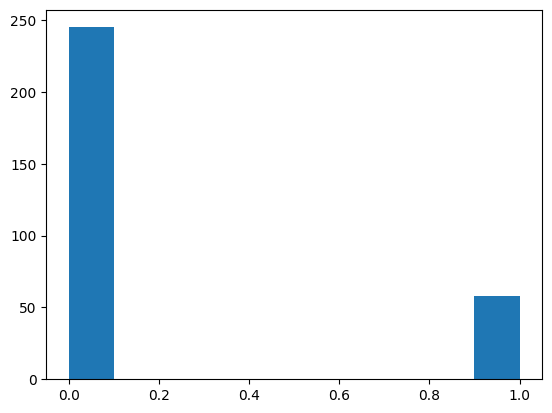

In [9]:
#Observe the frequency of each phenotypic class
plt.hist(X_Input_combined['petiole'])

In [6]:
#The frequency of class 0 is higher than that of class 1 --> We sub-sample 60 accessions in class 0 to ensure class balance
# Create masks for each phenotypic class
mask_0 = (X_Input_combined['petiole'] == 0)
mask_1 = (X_Input_combined['petiole'] == 1)

# Randomly sample the specified number of rows for each phenotypic class
sampled_rows_0 = X_Input_combined[mask_0].sample(60, random_state=1)
sampled_rows_1 = X_Input_combined[mask_1].sample(58, random_state=2)

# Concatenate the sampled dataframes to create a new dataframe
var = pd.concat([sampled_rows_0, sampled_rows_1])

# Reset the index of the new dataframe
var.reset_index(drop=True, inplace=True)

In [8]:
#change the name of the dataframe back to "X_Input_combined"
X_Input_combined = var

In [9]:
X_Input_combined.head(10)

FID        index  001_pos1029_T  001_pos1063_G  001_pos1188_C  001_pos1403_A  \
0    SRR15321713              0              0              2              0   
1    SRR15321943              0              0              0              0   
2    SRR15321896              0              0              0              0   
3    SRR15321915              0              0              2              0   
4    SRR15321747              0              0              1              0   
5    SRR15321913              0              0              0              0   
6    SRR15321702              0              0              0              0   
7    SRR15321801              0              0              1              0   
8    SRR15321924              1              0              0              1   
9    SRR15321646              0              0              0              0   

FID  001_pos2004_T  001_pos2244_C  001_pos2513_A  001_pos3177_T  \
0                0              0              0              0   
1                0              0              2              0   
2                0              0              2              0   
3                0              0              0              0   
4                0              0              1              0   
5                0              1              2              0   
6                0              0              2              0   
7                0              0              1              0   
8                0              0              1              1   
9                0              0              2              0   

FID  001_pos4038_T  ...  00199_pos6943_T  00202_pos7489_A  00202_pos7930_T  \
0                0  ...                0                0                2   
1                0  ...                0                0                0   
2                0  ...                0                0                0   
3                0  ...                0                0                0   
4                0  ...                0                0                0   
5                0  ...                0                0                0   
6                0  ...                1                0                1   
7                0  ...                0                0                1   
8                1  ...                0                0                1   
9                0  ...               -1                0                0   

FID  00202_pos7963_C  00202_pos8032_T  00202_pos8135_T  00202_pos9235_G  \
0                  0                0                0                0   
1                  0                0                0                0   
2                  0                0                0                1   
3                  0                0                0                1   
4                  0                0                0                0   
5                  0                0               -1                0   
6                  0                0                0                0   
7                  0                0                0                0   
8                  0                0               -1                0   
9                  0                2                0                2   

FID  00202_pos9290_A  00202_pos9351_A  petiole  
0                  0                0        0  
1                  0                0        0  
2                  0                1        0  
3                  0                0        0  
4                  0                0        0  
5                  0                0        0  
6                  0                0        0  
7                  0                0        0  
8                  0                0        0  
9                  0                0        0  

[10 rows x 4580831 columns]

(array([60.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 58.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

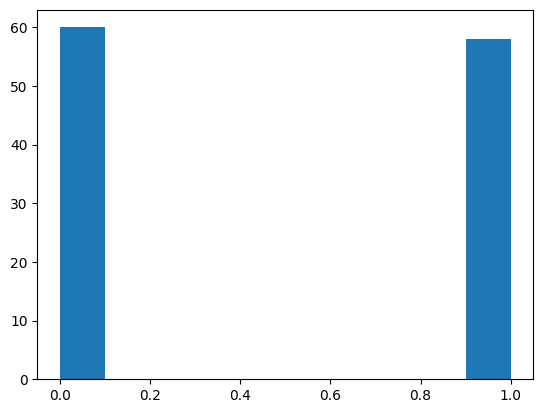

In [14]:
#Observe the classes' frequencies again
plt.hist(X_Input_combined['petiole'])

In [15]:
# Define functions for hyperopt that get the best loss and the best model from our training

def getBestModelfromTrials(trials):
    valid_trial_list = [trial for trial in trials
                            if STATUS_OK == trial['result']['status']]
    losses = [ float(trial['result']['loss']) for trial in valid_trial_list]
    index_having_minumum_loss = np.argmin(losses)
    best_trial_obj = valid_trial_list[index_having_minumum_loss]
    return best_trial_obj['result']['Trained_Model']

def getBestLossfromTrials(trials):
    valid_trial_list = [trial for trial in trials
                            if STATUS_OK == trial['result']['status']]
    losses = [ float(trial['result']['loss']) for trial in valid_trial_list]
    index_having_minumum_loss = np.argmin(losses)
    best_trial_obj = valid_trial_list[index_having_minumum_loss]
    return best_trial_obj['result']['loss']


In [16]:
# Define the objective Space to search for the best hyperparameters

space={ 'learning_rate'     : hp.choice('learning_rate', np.logspace(np.log10(0.005), np.log10(0.5), base = 10, num = 1000)),
        'max_depth': hp.choice('max_depth', range(5, 32, 1)),
        'gamma': hp.choice('gamma', [0.5, 1, 1.5, 2, 3, 4, 5]),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5 , 1.0 ),
        'subsample' : hp.uniform('subsample', 0.5,1.0),
        'min_child_weight' : hp.quniform('min_child_weight', 1, 10, 1),
        'scale_pos_weight'  : np.arange(0, 0.5, 1),
        'seed': 0,
        'nthread': 50
    }

In [17]:
# Define the function that scans the search space for the best hyperparameters

def objective(space):
    params = {"max_depth" : int(space['max_depth']), "gamma" : space['gamma'],
                    "min_child_weight":int(space['min_child_weight']),
                    "colsample_bytree" : (space['colsample_bytree']),
                    "subsample":(space['subsample']),
                    "learning_rate" :(space['learning_rate']),
                     "nthread" : -1}
    
    xgboost_train = xgb.DMatrix(data=X_train, label=y_train, weight = X_weights)
    
    num_boost_round=1000
    
    xgb_cv = xgb.cv(dtrain=xgboost_train,  params=params, \
                    num_boost_round=num_boost_round, \
                    early_stopping_rounds = 10, \
                    nfold=5,  metrics = 'error',seed=19, \
                    stratified=True) 
    
    n_rounds = len(xgb_cv["test-error-mean"])
    cv_score = xgb_cv["test-error-mean"][n_rounds-1]
    
    print( 'CV finished n_rounds={} cv_score={:7.5f}'.format( n_rounds, cv_score ) )

    
    print ("SCORE:", cv_score)
    return {'loss': cv_score, 'status': STATUS_OK,\
            'Trained_Model': params, 'rounds' : num_boost_round }

In [18]:
# Set X (genotypic data) and y (phenotypic data)

y = X_Input_combined['petiole'].values
X = X_Input_combined.drop(['petiole'], axis=1)

In [19]:
#Set the type of X to int8 to reduce memory usage
X=X.to_numpy(dtype=np.int8)

In [20]:
# If we have unbalanced datasets, we need to apply weights

classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=X_Input_combined['petiole'])


In [21]:
# Preprocess our labels into classes
le = preprocessing.LabelEncoder()
label_encoder = le.fit(y)
y_encoded = label_encoder.transform(y)

# set seed

seed = 37
# Split our dataset into a training and testing set using stratified sampling
X_train, X_test, y_train, y_test = \
train_test_split(X, y_encoded, stratify = y_encoded ,random_state = seed)

X_weights, X_test_drop, y_train_drop, y_test_drop = \
train_test_split(classes_weights, y_encoded, stratify = y_encoded ,random_state = seed)

In [24]:
# Run hyperparameter optimization

trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

print (best)


CV finished n_rounds=23 cv_score=0.28470                                                                              
SCORE:                                                                                                                
0.284696143323193                                                                                                     
CV finished n_rounds=16 cv_score=0.39799                                                                              
SCORE:                                                                                                                
0.397992715184829                                                                                                     
CV finished n_rounds=12 cv_score=0.36572                                                                              
SCORE:                                                                                                                
0.3657227899126075                              

SCORE:                                                                                                                
0.26317308768991243                                                                                                   
CV finished n_rounds=8 cv_score=0.24947                                                                               
SCORE:                                                                                                                
0.2494671668802792                                                                                                    
CV finished n_rounds=22 cv_score=0.28565                                                                              
SCORE:                                                                                                                
0.285650167857044                                                                                                     
CV finished n_rounds=17 cv_score=0.34219        

0.25157368744291897                                                                                                   
CV finished n_rounds=4 cv_score=0.27445                                                                               
SCORE:                                                                                                                
0.2744499687782559                                                                                                    
CV finished n_rounds=10 cv_score=0.37742                                                                              
SCORE:                                                                                                                
0.3774214259070697                                                                                                    
CV finished n_rounds=3 cv_score=0.34146                                                                               
SCORE:                                          

In [25]:
# Extract the best model and loss from the optimization
best_model = getBestModelfromTrials(trials)
best_loss = getBestLossfromTrials(trials)

In [26]:
# Show the best model 
best_model

{'max_depth': 31,
 'gamma': 1,
 'min_child_weight': 1,
 'colsample_bytree': 0.6260854281456235,
 'subsample': 0.8047700712577048,
 'learning_rate': 0.009937297747904918,
 'nthread': -1}

In [27]:
# Show the best loss

best_loss 

0.21674391216821057

In [28]:
# input the best model 

best_model = {'max_depth': 31,
 'gamma': 1,
 'min_child_weight': 1,
 'colsample_bytree': 0.6260854281456235,
 'subsample': 0.8047700712577048,
 'learning_rate': 0.009937297747904918,
 'nthread': -1}

### 2) Model fitting

In [29]:
# create a training matrix in the XGBoost format

xgboost_train = xgb.DMatrix(data=X_train, label=y_train)

# Create a model that uses the best parameters 

clf=xgb.XGBClassifier(**best_model, n_estimators = 100)

# fit the model

clf.fit(X_train, y_train, sample_weight=X_weights, eval_metric='error')

# predict the test data set

y_pred = clf.predict(X_test)

/home/andyngh/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


### 3) Results

In [30]:
# Classification Report
print(sklearn.metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.83      0.67      0.74        15
           1       0.72      0.87      0.79        15

    accuracy                           0.77        30
   macro avg       0.78      0.77      0.76        30
weighted avg       0.78      0.77      0.76        30



### 4) Model evaluation with 100 different testing data sets and feature importance extraction

In [33]:
best_model = {'max_depth': 31,
 'gamma': 1,
 'min_child_weight': 1,
 'colsample_bytree': 0.6260854281456235,
 'subsample': 0.8047700712577048,
 'learning_rate': 0.009937297747904918,
 'nthread': -1}

acc_array = np.array([])
feature_importance_full = []
for seed in range(1,101):
    
    #Split the data to create training and testing data sets
    X_train, X_test, y_train, y_test = \
    train_test_split(X, y_encoded, stratify = y_encoded ,random_state = seed)

    X_weights, X_test_drop, y_train_drop, y_test_drop = \
    train_test_split(classes_weights, y_encoded, stratify = y_encoded ,random_state = seed)

    
   #Model fitting and accuracy score calculation
    xgboost_train = xgb.DMatrix(data=X_train, label=y_train)
    clf=xgb.XGBClassifier(**best_model, n_estimators = 100)
    clf.fit(X_train, y_train, sample_weight=X_weights, eval_metric = 'error')
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    acc_array = np.append(acc_array, acc)
    
    #Feature importance extraction
    X_fi = X_Input_combined.drop(['petiole'], axis=1)
    feature_list = list(X_fi.columns)
    clf.get_booster().feature_names = feature_list
    feats = clf.get_booster().get_score(importance_type="gain")
    feature_importance_full.append(feats)



/home/andyngh/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/andyngh/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/andyngh/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/andyngh/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/hom

/home/andyngh/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/andyngh/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/andyngh/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/andyngh/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/hom

/home/andyngh/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/andyngh/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/andyngh/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/andyngh/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/hom

/home/andyngh/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


In [34]:
#Calculate the mean accuracy after 100 rounds of model evaluation
print(np.mean(acc_array))

0.7350000000000001


In [35]:
#Show the array containing accuracy scores from 100 rounds of model evaluation
print(acc_array)

[0.8        0.6        0.86666667 0.66666667 0.8        0.8
 0.93333333 0.83333333 0.73333333 0.63333333 0.76666667 0.6
 0.6        0.83333333 0.83333333 0.73333333 0.73333333 0.76666667
 0.73333333 0.7        0.66666667 0.7        0.63333333 0.63333333
 0.7        0.73333333 0.73333333 0.76666667 0.83333333 0.76666667
 0.76666667 0.63333333 0.7        0.8        0.63333333 0.73333333
 0.76666667 0.6        0.63333333 0.63333333 0.66666667 0.83333333
 0.73333333 0.76666667 0.73333333 0.63333333 0.73333333 0.63333333
 0.7        0.63333333 0.76666667 0.86666667 0.76666667 0.63333333
 0.63333333 0.76666667 0.7        0.7        0.76666667 0.76666667
 0.7        0.76666667 0.7        0.73333333 0.76666667 0.76666667
 0.73333333 0.7        0.8        0.9        0.73333333 0.73333333
 0.9        0.46666667 0.7        0.8        0.9        0.7
 0.7        0.96666667 0.76666667 0.56666667 0.76666667 0.73333333
 0.83333333 0.7        0.7        0.66666667 0.8        0.93333333
 0.8        0.73

In [36]:
#Create a dataframe comprising the importance scores of the variants
df = pd.DataFrame(feature_importance_full)
#Transpose the dataframe
df1 = df.T
#fill NaN with 0
df2 = df1.fillna(0) 
#Calculate the frequency of "0" in each row
df2['freq_0'] = df2.apply(lambda row: (row == 0).sum(), axis=1) 
#Sort the final table by the "freq_0" column
df_sorted = df2.sort_values('freq_0', ascending=True) 
#Filter out the rows with freq_0 > 80
final_df = df_sorted[df_sorted['freq_0'] < 80]
print(final_df)

                               0          1          2          3          4  \
001_pos10286959_A      19.164068  19.194592  14.978432  18.386496  17.504784   
004_pos3321021_T       13.218307   0.000000  14.061653   0.000000  17.602766   
004_pos3319290_A       21.457787   0.000000   0.000000   0.000000  10.081758   
001_pos131178919_G      0.000000  28.139315   0.000000   0.000000   0.000000   
006_pos135565554_G     15.787652  21.858238   0.000000  17.787445  16.273333   
004_pos163612769_AT     0.000000   0.000000   0.000000  15.340779   0.000000   
004_pos3320794_G       18.064663   0.000000   0.000000   0.000000  18.805958   
004_pos3321216_CCTAG   12.586062   0.000000   0.000000   0.000000  13.680560   
001_pos116369039_T      0.000000   0.000000  10.328218   0.000000  17.296162   
001_pos131172658_T     16.309158   0.000000  24.560930   0.000000  12.219603   
006_pos146390160_A      0.000000  13.428753   0.000000  13.215046   0.000000   
005_pos4165904_G        0.000000   0.000

In [37]:
#Save the filtered feature importance dataframe
final_df.to_csv('New_imp_petiole_filtered.csv')

### 5) Model significance and correlation analysis 

Model significance

In [ ]:
#Import modules
from sklearn.utils import class_weight
from sklearn.dummy import DummyClassifier
from mlxtend.evaluate import paired_ttest_5x2cv

In [ ]:
#Create a baseline model
dummy = DummyClassifier(strategy="most_frequent")

In [ ]:
#Perform the paired t-test to compare the best model and the baseline model
t, p = paired_ttest_5x2cv(estimator1=clf, estimator2=dummy, X=X, y=y, random_seed=1)
print(t) # t= 3.872983346207414
print(p) # p = 0.011724811003954675

Correlation analysis

In [ ]:
#Input the columns comprising the most important variants indentified above  
target_columns = ["001_pos10286959_A",
"004_pos3321021_T",
"004_pos3319290_A",
"001_pos131178919_G",
"006_pos135565554_G",
"004_pos163612769_AT",
"004_pos3320794_G",
"004_pos3321216_CCTAG",
"001_pos116369039_T",
"001_pos131172658_T",
"006_pos146390160_A",
"005_pos4165904_G",
"006_pos122544661_G",
"004_pos9258969_A",
"001_pos10261102_G",
"002_pos41110960_A",
"002_pos81741072_T",
"006_pos148214276_T",
"006_pos135565759_C",
"002_pos80654997_T",
"004_pos160561896_A",
"004_pos7763254_C",
"004_pos3319716_T",
"004_pos25017527_A",
"002_pos80586117_GAATT",
"006_pos36965790_G",
"006_pos91435635_T",
"002_pos32382869_G",
"006_pos122545568_A",
"004_pos162378221_C",
"004_pos17151789_C",
"001_pos125351370_T",
"003_pos17447831_T"]

In [ ]:
#Calculate Pearson correlation coefficients between each important variants and the whole variant set 
correlation_results = {}
for target_column in target_columns:
    #Extract the important variants from the dataframe
    target = X_Input_combined[target_column]
    #Extract the remaining variants from the dataframe
    numeric_columns = X_Input_combined.drop(columns=['petiole', target_column])
    #Calculate the correlation coefficient
    correlations = numeric_columns.corrwith(target, method='pearson')
    #Filter out the correlation coefficients with absolute values < 0.97
    filtered_correlations = correlations[abs(correlations) >= 0.97]
    #Put the filtered coefficients into a dictionary
    correlation_results[target_column] = filtered_correlations